In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from matplotlib import pyplot
import descartes
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MultiLabelBinarizer
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


In [2]:
airbnb = pd.read_csv('../data/preprocessing/airbnb.csv')

In [3]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222 entries, 0 to 2221
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   the_geom                        2222 non-null   object 
 1   OBJECTID                        2222 non-null   int64  
 2   geoid                           2222 non-null   int64  
 3   Median Sales Price              2222 non-null   float64
 4   PercentShortTermRentals         2222 non-null   float64
 5   geometry                        2222 non-null   object 
 6   index_right                     2222 non-null   int64  
 7   id                              2222 non-null   int64  
 8   name                            2222 non-null   object 
 9   description                     2222 non-null   object 
 10  neighborhood_overview           2222 non-null   object 
 11  host_name                       2222 non-null   object 
 12  host_location                   22

In [4]:
targets= ['price_person','middle_estimate/month', 'lowest_estimate/month','price']

In [5]:
#this removes features that I won't use for modeling. I'll keep them in a separate dataframe incase I want to use 
#spacial information or NLP in the future. 
reserved_features = ['the_geom', 'geometry','OBJECTID', 'geoid', 'index_right','id', 'latitude', 'longitude', 'name', 'description', 'neighborhood_overview', 'host_name', 'host_location', 'host_about']
reserved_df = airbnb[reserved_features]
airbnb = airbnb.drop(columns = reserved_features)

# Dummy Variables and One Hot Encoding

The first thing I want to do is make a dataframe for linear regression and one for tree based ensembles. For linear regression, the categorical columns will need to be turned into multiple columns for each category. One Hot Encoding does this by turning each category into its own column and Get Dummies does this by making a column for each category - 1. For categories that are mutually exclusive I should use Dummy Variables and for categories that aren't, I'll use one hot encoding.

## One Hot Encoding for Amenities

I'll use multiplabelbinarizer from sklearn preprocessing to make a column for each amenity listed and fill in 1s for airbnbs with that amenity and fill in 0s for aibnbs without.  Since each instance can contain any combination of amenities, this will be like one hot encoding.

In [6]:
airbnb.amenities.head()

0    ["Wifi", "Long term stays allowed", "Hair drye...
1    ["Wifi", "Long term stays allowed", "Hair drye...
2    ["Lockbox", "Wifi", "Long term stays allowed",...
3    ["Wifi", "Long term stays allowed", "Hair drye...
4    ["Lockbox", "Wifi", "Long term stays allowed",...
Name: amenities, dtype: object

In [7]:
#prepping amenities colulumn to work with multilabelbinarizer
#binarizer method works by separating the words in one string into categories that do not repeat. 
#so I have to remove:
#the brakets
airbnb['amenities']=airbnb['amenities'].map(lambda x: x.lstrip('[').rstrip(']'))
#the quotation marks 
airbnb['amenities']=airbnb['amenities'].map(lambda x: x.replace('"',''))
#and leading whitespaces
airbnb['amenities']=airbnb['amenities'].map(lambda x: x.replace(', ',','))

In [8]:
print(airbnb.amenities[:5])

0    Wifi,Long term stays allowed,Hair dryer,Shampo...
1    Wifi,Long term stays allowed,Hair dryer,Shampo...
2    Lockbox,Wifi,Long term stays allowed,Hair drye...
3    Wifi,Long term stays allowed,Hair dryer,Shampo...
4    Lockbox,Wifi,Long term stays allowed,Hair drye...
Name: amenities, dtype: object


In [9]:
#creates a new data frame of amenities as separate columns with boolean values
mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(airbnb['amenities'].str.split(',')),columns=mlb.classes_)
print(amenities_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222 entries, 0 to 2221
Data columns (total 94 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Air conditioning                2222 non-null   int64
 1   BBQ grill                       2222 non-null   int64
 2   Baby bath                       2222 non-null   int64
 3   Baby monitor                    2222 non-null   int64
 4   Babysitter recommendations      2222 non-null   int64
 5   Baking sheet                    2222 non-null   int64
 6   Barbecue utensils               2222 non-null   int64
 7   Bathroom essentials             2222 non-null   int64
 8   Bathtub                         2222 non-null   int64
 9   Beach essentials                2222 non-null   int64
 10  Beachfront                      2222 non-null   int64
 11  Bed linens                      2222 non-null   int64
 12  Bedroom comforts                2222 non-null   int64
 13  Bre

In [10]:
#checks to see if any amenities are used by each airbnb and therefore have no variance
col_list=[]
for col in amenities_df.columns:    
    if amenities_df[col].nunique()<2:
        col_list.append(col)
print("There are " +str(len(col_list)) + ' columns with fewer than 2 unique values')

There are 0 columns with fewer than 2 unique values


In [11]:
#joins main dataframe with amenities dataframe with a prefix. 
airbnb = airbnb.reset_index()
airbnb = airbnb.join(amenities_df.add_prefix('amen_'))


## Finding and Transforming Other Categorical Features


In [12]:
#first change boolean columns to integers
boolean = airbnb.select_dtypes(bool).columns
for col in airbnb[boolean]:
    airbnb[col]=np.multiply(airbnb[col], 1)

#then make a dataframe to look at columns that need to be encoded by removing numeric
numeric = airbnb.select_dtypes(np.number).columns
other = airbnb.drop(columns = numeric)
other.dtypes

host_response_time        object
neighbourhood_cleansed    object
property_type             object
amenities                 object
dtype: object

In [13]:
#dropping amenities since it already has been encoded. 
other.drop(columns = 'amenities', inplace = True)

In [14]:
#making dummy columns with prefixes
dummy_columns = other.columns
prefixes = ['resp_tim_','nbhd_','prop']
prefixes = dict(zip(dummy_columns, prefixes))
other = pd.get_dummies(data = other, prefix = prefixes, drop_first = True)

In [15]:
linear_data = airbnb[numeric].join(other)
linear_data.drop(columns = 'index', inplace = True)
print(linear_data.shape)
linear_data.head()

(2222, 225)


,Median Sales Price,PercentShortTermRentals,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms_text,bedrooms,...,prop_Private room in guest suite,prop_Private room in guesthouse,prop_Private room in hostel,prop_Private room in house,prop_Private room in loft,prop_Private room in resort,prop_Private room in townhouse,prop_Room in aparthotel,prop_Room in boutique hotel,prop_Tiny house
0,134250.0,4.626335,100.0,100.0,1,1,1,8,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
1,134250.0,4.626335,96.0,98.0,0,1,1,6,2.5,3.0,...,0,0,0,0,0,0,0,0,0,0
2,134250.0,4.626335,100.0,84.0,1,1,1,4,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,134250.0,4.626335,95.0,99.0,0,1,1,6,2.5,3.0,...,0,0,0,0,0,0,0,0,0,0
4,134250.0,4.626335,100.0,100.0,0,1,1,8,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print(airbnb.shape)
airbnb.head()

(2222, 135)


,index,Median Sales Price,PercentShortTermRentals,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,amen_Smoking allowed,amen_Stair gates,amen_Stove,amen_Suitable for events,amen_TV,amen_Table corner guards,amen_Washer,amen_Waterfront,amen_Wifi,amen_Window guards
0,0,134250.0,4.626335,within an hour,100.0,100.0,1,1,1,Treme - Lafitte,...,0,0,1,0,1,0,1,0,1,0
1,1,134250.0,4.626335,within an hour,96.0,98.0,0,1,1,Treme - Lafitte,...,0,0,1,0,1,0,1,0,1,0
2,2,134250.0,4.626335,within an hour,100.0,84.0,1,1,1,Treme - Lafitte,...,0,0,0,0,1,0,0,0,1,0
3,3,134250.0,4.626335,within an hour,95.0,99.0,0,1,1,Treme - Lafitte,...,0,0,1,0,1,0,1,0,1,0
4,4,134250.0,4.626335,within an hour,100.0,100.0,0,1,1,Treme - Lafitte,...,0,0,0,0,1,0,1,0,1,0


## Data Split for Decision Tree or Linear Regression
The linear_data dataset is now completely encoded for linear regression.
The airbnb dataset can be used for decision tree type regressions such as the random forest regressor. The amenities are encoded, but the other categorical and boolean features are kept as they are. 










# Feature Selection

Encoding created a lot of features. The following will try to address feature selection.  I would like to select features rather than extract with PCA.  I've chosen homeowners as my target audience and I want to stick with methods that easily show what aspects of a rental affect its price. 

## Colinearity

Linear regression will be negatively affected by co and multilinearity in independant features. The following section will address this issue. 

In [17]:

corr=linear_data.drop(columns = targets).corr().abs()
corr = corr.unstack().sort_values().reset_index()
corr = corr[corr['level_0']!=corr['level_1']]#removes columns correlated with themselves from analysis

#takes the correlated data and removes duplicates. otherwise data frame will have feature 1 - feature 2 and feature 2 - feature 1
corr['ordered-cols'] = corr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr = corr.drop_duplicates(['ordered-cols'])
corr.drop(['ordered-cols'], axis=1, inplace=True)

In [18]:
print(corr.shape)
print(corr.tail(5))

(24310, 3)
                     level_0                          level_1         0
48610        availability_60                  availability_30  0.936361
48612       Restaurant_Count  nbhd__Central Business District  0.937354
48614        availability_60                  availability_90  0.973160
48616            amen_Washer                       amen_Dryer  0.973593
48711  amen_Bedroom comforts         amen_Bathroom essentials  1.000000


In [19]:
#finds correlation price_person has with each feature for comparison
price_0 = []
price_1 = []#lists for storing results
for i, r in corr.iterrows():
    column0 = corr.level_0[i]
    column1 = corr.level_1[i]
    price_0.append(abs(linear_data['price_person'].corr(linear_data[column0])))
    price_1.append(abs(linear_data['price_person'].corr(linear_data[column1])))


In [20]:
#makes a new columns to compare price correlation with feature 0 with price correlation with feature 1. 
corr = corr.reset_index()
corr['price_0'] = pd.Series(price_0)
corr['price_1'] = pd.Series(price_1)

In [21]:
corr[corr[0]>.7]#filters rows with high colinearity
remove = []#starts a list for storing values

for i, row in corr[corr[0]>.7].iterrows():#loop that appends the feature with the smaller correlation to price 
    if corr.price_0[i]<corr.price_1[i]:
        remove.append(corr.level_0[i])
    else:
        remove.append(corr.level_1[i])
remove = set(remove)#makes list unique
print(remove)
print(len(remove))

{'bathrooms_text', 'amen_Dryer', 'amen_Bathroom essentials', 'Restaurant_Count', 'amen_Dishes and silverware', 'review_scores_value', 'amen_Self check-in', 'review_scores_accuracy', 'neighborhood_restaurants', 'amen_Full kitchen', 'bedrooms', 'resp_tim__within a few hours', 'availability_30', 'amen_Stove', 'number_of_reviews', 'amen_Cooking basics', 'amen_Essentials', 'amen_Elevator', 'amen_Refrigerator', 'beds', 'availability_60'}
21


In [22]:
lin_reg_data = linear_data.drop(columns = remove)#makes a new data frame that removes colinear features.
price_corr = {}#dictionary for storing
for column in lin_reg_data.drop(columns = targets).columns:#iterates over columns other than targets
    price_corr[column] = abs(lin_reg_data['price_person'].corr(lin_reg_data[column]))#finds correlation between column and price. 

price_corr = pd.DataFrame(price_corr.items())#stores dict to dataframe for easier filtering

In [23]:
price_corr = price_corr.sort_values(1, ascending = False)#sort values by descending correlation to price
highest_20 = list(price_corr[0][:20])#list to keep 20 most correlated values 
lin_reg_data = lin_reg_data[highest_20]

## Conclusion
There should now be appropriate features for decision tree regressions, standard linear regression and lasso regressions. 

In [24]:
airbnb.price_person

0       18.000000
1       15.833333
2       17.607500
3       15.000000
4       11.125000
          ...    
2217    25.166667
2218    25.000000
2219    25.750000
2220    31.125000
2221    11.250000
Name: price_person, Length: 2222, dtype: float64

In [25]:
linear_data[remove].to_csv(r'../data/modeling/co_linear.csv')
linear_data.to_csv(r'../data/modeling/airbnb.csv')
airbnb[targets].to_csv(r'../data/modeling/targets.csv')
lin_reg_data.to_csv(r'../data/modeling/linear_data.csv')

In [26]:
linear_data.head()

,Median Sales Price,PercentShortTermRentals,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms_text,bedrooms,...,prop_Private room in guest suite,prop_Private room in guesthouse,prop_Private room in hostel,prop_Private room in house,prop_Private room in loft,prop_Private room in resort,prop_Private room in townhouse,prop_Room in aparthotel,prop_Room in boutique hotel,prop_Tiny house
0,134250.0,4.626335,100.0,100.0,1,1,1,8,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
1,134250.0,4.626335,96.0,98.0,0,1,1,6,2.5,3.0,...,0,0,0,0,0,0,0,0,0,0
2,134250.0,4.626335,100.0,84.0,1,1,1,4,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,134250.0,4.626335,95.0,99.0,0,1,1,6,2.5,3.0,...,0,0,0,0,0,0,0,0,0,0
4,134250.0,4.626335,100.0,100.0,0,1,1,8,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
airbnb.head()

,index,Median Sales Price,PercentShortTermRentals,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,amen_Smoking allowed,amen_Stair gates,amen_Stove,amen_Suitable for events,amen_TV,amen_Table corner guards,amen_Washer,amen_Waterfront,amen_Wifi,amen_Window guards
0,0,134250.0,4.626335,within an hour,100.0,100.0,1,1,1,Treme - Lafitte,...,0,0,1,0,1,0,1,0,1,0
1,1,134250.0,4.626335,within an hour,96.0,98.0,0,1,1,Treme - Lafitte,...,0,0,1,0,1,0,1,0,1,0
2,2,134250.0,4.626335,within an hour,100.0,84.0,1,1,1,Treme - Lafitte,...,0,0,0,0,1,0,0,0,1,0
3,3,134250.0,4.626335,within an hour,95.0,99.0,0,1,1,Treme - Lafitte,...,0,0,1,0,1,0,1,0,1,0
4,4,134250.0,4.626335,within an hour,100.0,100.0,0,1,1,Treme - Lafitte,...,0,0,0,0,1,0,1,0,1,0


<AxesSubplot:>

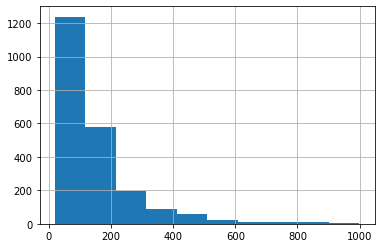

In [34]:
airbnb.price.hist()

<AxesSubplot:>

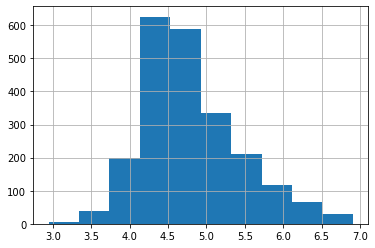

In [35]:
np.log(airbnb.price).hist()